In [178]:
#=====BIEN PENSER A LANCER LES CELLULES DANS L'ORDRE D'APPARITION (cellule 1 -> cellule 2 ...)===== 

import requests
import json
import pandas as pd
import time
import os, sys
import PIL 
from PIL.ExifTags import TAGS
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import math
import random 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report
import graphviz
import pydotplus
import platform
import webcolors
from collections import Counter
import IPython.display 


In [179]:
# -------------------------------------------------------------------------------------------------------------------------
# ----- A LANCER UNE SEULE FOIS !! ---------------------------------------------------------------------------------------- 
#--------------------------------------------------------------------------------------------------------------------------
# ----- A LANCER UNIQUEMENT POUR METTRE A JOUR LES DONNES DANS LES FICHIER movie_response.json et genre_response.json -----
# -------------------------------------------------------------------------------------------------------------------------

# REQUETE HTTP POUR OBTENIR LA LISTE DE FILMS 
url = "https://api.themoviedb.org/3/list/1235?api_key=788aa7e71377cd8762740dab9060e85f"
response1 = requests.get(url)

# REQUETE HTTP POUR OBTENIR LA LISTE DES GENRES
url2 = "https://api.themoviedb.org/3/genre/movie/list?api_key=788aa7e71377cd8762740dab9060e85f"
response2 = requests.get(url2)

# ----------------------------------------------------------
# ----------------------------------------------------------
# ----------------------------------------------------------

In [180]:
# ECRITURE DES REPONSES HTTP DANS UN FICHIER JSON 

# écriture dans movie_response.json
if response1.ok:
    movies = response1.json()['items']
    with open(os.path.join(os.getcwd(),'tmdb_responses','movies_response.json'), 'w') as f:
        json.dump(movies, f, indent=4)
else:
    print("Problème avec la requête 1 (liste de films)")
    
# écriture dans genre_response.json
if response2.ok:
    genres = response2.json()['genres']
    with open(os.path.join(os.getcwd(),'tmdb_responses','genres_response.json'), 'w') as f:
        json.dump(genres, f, indent=4) 
else:
    print("Problème avec la requête 2 (liste de genres)")

In [181]:
# RECUPERATION DES DONNES JSONS ET TRANSFORMATIONS DES DONNES EN LISTES DE DICTIONNAIRES PYTHON
with open(os.path.join(os.getcwd(),'tmdb_responses','movies_response.json'), 'r') as f:
    movies = json.load(f) # ---> movies est une liste de 100 films
with open(os.path.join(os.getcwd(),'tmdb_responses','genres_response.json'), 'r') as f:
    genres = json.load(f) #--> genres est une liste des genres existants pour les films

In [182]:
# VISUALISATION DES INFOS SUR GENRES EXISTANTS, ON A LE LIEN GENRE_ID <--> NOM DU GENRE
genres_df = pd.json_normalize(genres)
genres_df.set_index('id', inplace=True)
genres_df.sort_values(by='id', inplace=True)
genres_df


,name
id,
12,Adventure
14,Fantasy
16,Animation
18,Drama
27,Horror
28,Action
35,Comedy
36,History
37,Western


In [183]:
# VISUALISATION DES INFOS SUR LES 100 FILMS, CLASSES PAR POPULARITE

movies_df = pd.json_normalize(movies)

# on sélectionne les colonnes que l'on veut
movies_df = movies_df[['id','popularity','title','release_date','genre_ids', 'original_language','overview']]

#dataframe indexé par les id tmdb, ça va être utile pour lier chaque film à son poster 
movies_df.set_index('id', inplace=True)

#classement par popularité
movies_df.sort_values(by=['id'], ascending=True, inplace=True)
movies_df

# on garde uniquement l'année de publication du film (et supprime le moi et le jour)
movies_df['release_date'] = movies_df['release_date'].apply(lambda x: x.split('-')[0]) 


# le but ici est d'obtenir dans la série genres_id non plus des listes d'id mais des listes de genres correspondant au ids
def id_to_genres(list_of_ids):
    list_of_genres = []
    for id in list_of_ids:
        list_of_genres.append(genres_df.loc[id, 'name'])
    return list_of_genres[0]
movies_df['genre_ids'] = movies_df['genre_ids'].apply(id_to_genres)
#comme nous n'avons plus de liste d'ids nous renommons la colonne genres, tout simplement !
movies_df.rename(columns={'genre_ids': 'genres'}, inplace=True)
def order_by_year(year): #on groupe les années pour simplifier
    year = int(year)
    if year in range(1916,1920):
        return '10s'
    elif year in range(1920,1930):
        return '20s'
    elif year in range(1930,1940):
        return '30s'
    elif year in range(1940,1950):
        return '40s'
    elif year in range(1950,1960):
        return '50s'
    elif year in range(1960,1970):
        return '60s'
    elif year in range(1970,1980):
        return '70s'
    elif year in range(1980,1990):
        return '80s'
    elif year in range(1990,2000):
        return '90s'
    elif year in range(2000,2010):
        return '2000s'
    elif year in range(2010,2020):
        return '2010s'
    else:
        return '2020s'
    
movies_df['release_date'] = movies_df['release_date'].apply(order_by_year)
movies_df.rename(columns={'release_date': 'release_period'}, inplace=True)
movies_df

,popularity,title,release_period,genres,original_language,overview
id,,,,,,
11,71.643,Star Wars,70s,Adventure,en,Princess Leia is captured and held hostage by ...
13,71.155,Forrest Gump,90s,Comedy,en,A man with a low IQ has accomplished great thi...
15,19.784,Citizen Kane,40s,Mystery,en,"Newspaper magnate, Charles Foster Kane is take..."
28,36.800,Apocalypse Now,70s,Drama,en,"At the height of the Vietnam war, Captain Benj..."
33,31.418,Unforgiven,90s,Western,en,"William Munny is a retired, once-ruthless kill..."
...,...,...,...,...,...,...
16305,8.451,Sullivan's Travels,40s,Adventure,en,"Successful movie director John L. Sullivan, co..."
20325,7.006,Swing Time,30s,Comedy,en,Lucky is tricked into missing his own wedding ...
25188,13.025,The Last Picture Show,70s,Drama,en,"High school seniors and best friends, Sonny an..."


In [146]:
# TELECHARGEMENT DES POSTERS DES FILMS, DESTINATION DANS ./images

#On s'assure que le dossier images existe
path_images=os.path.join('.','images')

if os.path.isdir(path_images): #si le dossier 'images' existe déjà
    pass
else:
    os.mkdir(path_images) #création du dossier 'images'
    
# On télécharge les images
for movie in movies:
    binary_data_img = requests.get("https://image.tmdb.org/t/p/w500" + movie['poster_path']).content
    try:
        with open(os.path.join(os.getcwd(),'images',movie['original_title'].replace(':', '_').replace(' ', '_').replace('*', '_')+'.jpg'), 'wb') as file:
            file.write(binary_data_img)
        time.sleep(0.5)
    except:
        pass
        

Nombre de couleurs dominantes trouvées:  1
Nombre de couleurs dominantes trouvées:  2
Nombre de couleurs dominantes trouvées:  3
Nombre de couleurs dominantes trouvées:  4
Nombre de couleurs dominantes trouvées:  5
Nombre de couleurs dominantes trouvées:  6
Nombre de couleurs dominantes trouvées:  7
Nombre de couleurs dominantes trouvées:  8
Nombre de couleurs dominantes trouvées:  9
Nombre de couleurs dominantes trouvées:  10
Nombre de couleurs dominantes trouvées:  11
Nombre de couleurs dominantes trouvées:  12
===CALCULS DES COULEURS FINIS===


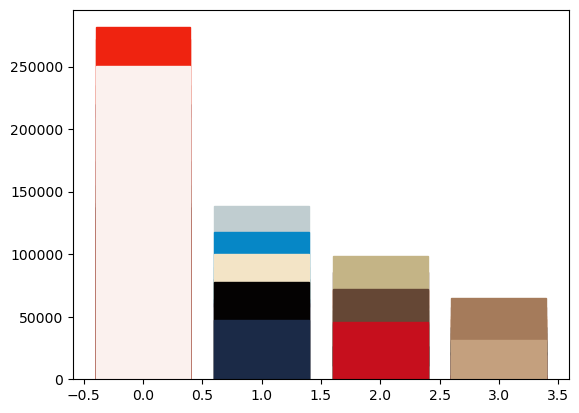

In [184]:
# DETERMINATION DE LA COULEUR DOMINANTE

img_file_list = os.listdir('images') 

img_file_list

def get_path(img_name):
        return os.path.join(os.getcwd(),'images',img_name)
img_path_list = [get_path(x) for x in img_file_list if x != '.ipynb_checkpoints']

movies_dict = movies_df.to_dict(orient='records')

compteur_film = 0
nomb_bins = 4
liste_film_couleur_dominante_trouvee = []
dico_couleur = {}

if platform.system() == "Linux":
    carac="/"
else:
    carac="\\"

for path in img_path_list:
    try:
        imgfile = PIL.Image.open(path)
        numarray = np.array(imgfile.getdata(), np.uint8)

        clusters = KMeans(n_clusters=nomb_bins, n_init=2)
        clusters.fit(numarray)
        npbins = np.arange(0, nomb_bins+1)
        histogram = np.histogram(clusters.labels_, bins=npbins)
        labels = np.unique(clusters.labels_)
        descending_histogram = np.flip(np.sort(histogram[0]))
        barlist = plot.bar(labels, descending_histogram)

        #On créé une liste qui contiendra les code rgb des différentes bar plots.
        rgb_list = []
        for i in range(nomb_bins):
            rgb_code = "#%02x%02x%02x" % (math.ceil(clusters.cluster_centers_[i][0]),math.ceil(clusters.cluster_centers_[i][1]), math.ceil(clusters.cluster_centers_[i][2]),)
            rgb_list.append(rgb_code)
            barlist[i].set_color(rgb_code)
        
        index_max = np.argmax(barlist.datavalues)
        couleur = rgb_list[index_max] # couleur dominante du poster (barre la plus haute)
        
        composantes = couleur.split('#')[1]
        
        #récupération des composantes RGB
        r = int('0x' + composantes[0:2], 16) 
        g = int('0x' + composantes[2:4], 16)
        b = int('0x' + composantes[4:6], 16)
        temp = [r,g,b]
    
        min_colours = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - temp[0]) ** 2
            gd = (g_c - temp[1]) ** 2
            bd = (b_c - temp[2]) ** 2
            min_colours[(rd + gd + bd)] = name
            
        couleur_dominante = min_colours[min(min_colours.keys())] #on cherche la couleur la plus proche de la nôtre
        
        for dico in movies_dict:
            img_name =  path.split(carac)[-1].split('.')[0].replace('_',' ') 
            if img_name == dico['title']:
                compteur_film += 1
                print("Nombre de couleurs dominantes trouvées: ", compteur_film)  
                temp = {"couleur_dominante_du_poster": couleur_dominante}
                dico.update(temp)
                liste_film_couleur_dominante_trouvee.append(dico) #liste contenant que les films traités actuellement
            
        dico_couleur[couleur_dominante] = couleur
        
    
    except Exception as e:
        print(e)
        

print("===CALCULS DES COULEURS FINIS===")       

data = pd.DataFrame(liste_film_couleur_dominante_trouvee)

In [185]:
# On enregistre les données bien formatées dans un fichier json
data.to_json(os.path.join(os.getcwd(),'data','movies.json'),orient="records", indent=4)

In [192]:
data2 = data[['genres','release_period','couleur_dominante_du_poster']]
data3 = data.copy()
data2_copy = data2.copy()

preferences = ['Favorite', 'NotFavorite']

#on crée 3 listes contenenant les préférences des 3 utilisateurs
users_preferences = { 
    'user0': [],
    'user1': [],
    'user2': []
}
for user in users_preferences:
    for i in range(len(data2.index)):
        users_preferences[user].append(random.sample(preferences,1)[0]) #on ajoute 'Favorite' ou 'NotFavorite' aléatoirement

---SUGGESTIONS OF TAGS--- [['Animation', '50s', 'darkslategray'], ['Animation', '60s', 'rosybrown'], ['Drama', '40s', 'whitesmoke'], ['Adventure', '90s', 'orangered'], ['Drama', '80s', 'chocolate'], ['Western', '60s', 'chocolate'], ['Western', '50s', 'sienna'], ['Animation', '60s', 'rosybrown'], ['Comedy', '40s', 'black'], ['Animation', '50s', 'orangered'], ['Adventure', '50s', 'chocolate'], ['Western', '50s', 'orangered'], ['Crime', '40s', 'black'], ['Mystery', '40s', 'orangered'], ['Western', '30s', 'orangered'], ['Adventure', '60s', 'darkslategray'], ['Adventure', '80s', 'chocolate'], ['Western', '40s', 'sienna'], ['Crime', '40s', 'seagreen'], ['Drama', '80s', 'rosybrown'], ['Mystery', '40s', 'rosybrown'], ['Comedy', '80s', 'sienna'], ['Crime', '90s', 'darkslategray'], ['Animation', '60s', 'orangered'], ['Drama', '60s', 'seashell'], ['Adventure', '60s', 'orangered'], ['Adventure', '80s', 'black'], ['Drama', '60s', 'whitesmoke'], ['Animation', '40s', 'rosybrown'], ['Drama', '60s', 'b

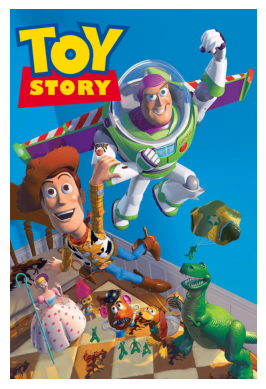

user0: Favorite or Not Favorite ? (y/n --- stop => s): y


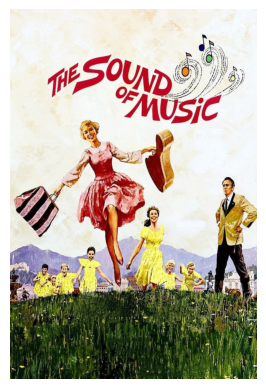

user0: Favorite or Not Favorite ? (y/n --- stop => s): s


---FAVORITE FILMS--- ['Toy Story']


===VOICI L'ARBRE DE DECISION POUR L'UTILISATEUR 0===


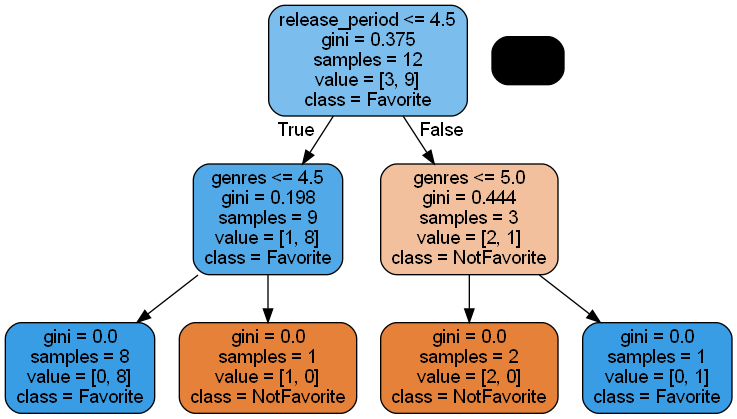

---SUGGESTIONS OF TAGS--- [['Crime', '50s', 'black'], ['Drama', '40s', 'orangered'], ['Comedy', '30s', 'orangered'], ['Animation', '50s', 'rosybrown'], ['Western', '90s', 'rosybrown'], ['Western', '60s', 'orangered'], ['Western', '60s', 'seagreen'], ['Crime', '90s', 'whitesmoke'], ['Mystery', '50s', 'black'], ['Mystery', '90s', 'orangered'], ['Adventure', '80s', 'rosybrown'], ['Mystery', '60s', 'orangered'], ['Mystery', '30s', 'seagreen'], ['Adventure', '50s', 'darkslategray'], ['Western', '50s', 'whitesmoke'], ['Crime', '40s', 'orangered'], ['Mystery', '40s', 'whitesmoke'], ['Mystery', '80s', 'darkslategray'], ['Mystery', '60s', 'darkslategray'], ['Adventure', '30s', 'sienna'], ['Adventure', '90s', 'chocolate'], ['Crime', '90s', 'orangered'], ['Crime', '40s', 'whitesmoke'], ['Animation', '40s', 'black'], ['Drama', '40s', 'seashell'], ['Animation', '30s', 'whitesmoke'], ['Western', '90s', 'darkslategray'], ['Western', '50s', 'rosybrown'], ['Adventure', '60s', 'black'], ['Animation', '3

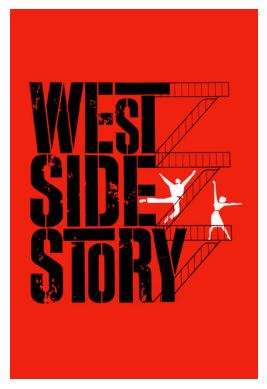

user1: Favorite or Not Favorite ? (y/n --- stop => s): y


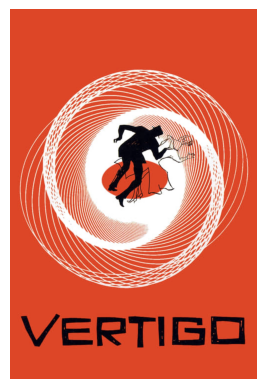

user1: Favorite or Not Favorite ? (y/n --- stop => s): s


---FAVORITE FILMS--- ['West Side Story']


===VOICI L'ARBRE DE DECISION POUR L'UTILISATEUR 1===


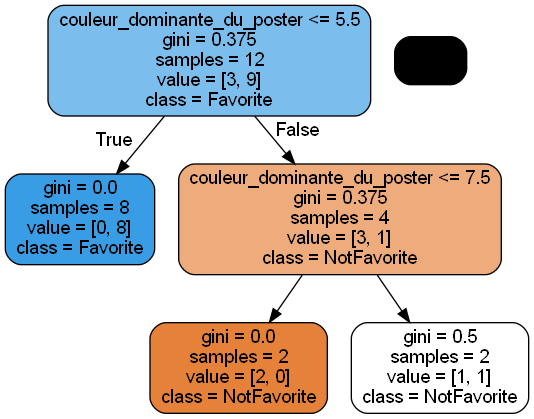

---SUGGESTIONS OF TAGS--- [['Western', '50s', 'chocolate'], ['Crime', '80s', 'sienna'], ['Adventure', '60s', 'orangered'], ['Adventure', '30s', 'sienna'], ['Crime', '30s', 'darkslategray'], ['Comedy', '40s', 'whitesmoke'], ['Comedy', '60s', 'darkslategray'], ['Western', '90s', 'sienna'], ['Comedy', '60s', 'chocolate'], ['Animation', '90s', 'seagreen'], ['Animation', '60s', 'seashell'], ['Western', '90s', 'orangered'], ['Comedy', '80s', 'sienna'], ['Animation', '90s', 'whitesmoke'], ['Western', '40s', 'black'], ['Drama', '60s', 'whitesmoke'], ['Animation', '60s', 'seashell'], ['Drama', '60s', 'black'], ['Western', '80s', 'black'], ['Crime', '40s', 'seashell'], ['Western', '30s', 'seashell'], ['Animation', '30s', 'darkslategray'], ['Western', '90s', 'whitesmoke'], ['Adventure', '40s', 'darkslategray'], ['Animation', '30s', 'sienna'], ['Animation', '40s', 'orangered'], ['Animation', '80s', 'seashell'], ['Comedy', '80s', 'seagreen'], ['Animation', '40s', 'seashell'], ['Crime', '50s', 'whit

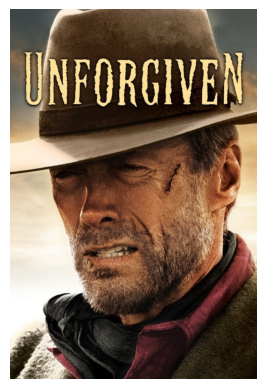

user2: Favorite or Not Favorite ? (y/n --- stop => s): y


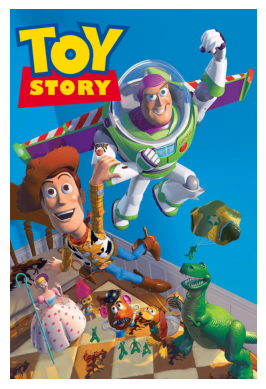

user2: Favorite or Not Favorite ? (y/n --- stop => s): s


---FAVORITE FILMS--- ['Unforgiven']


===VOICI L'ARBRE DE DECISION POUR L'UTILISATEUR 2===


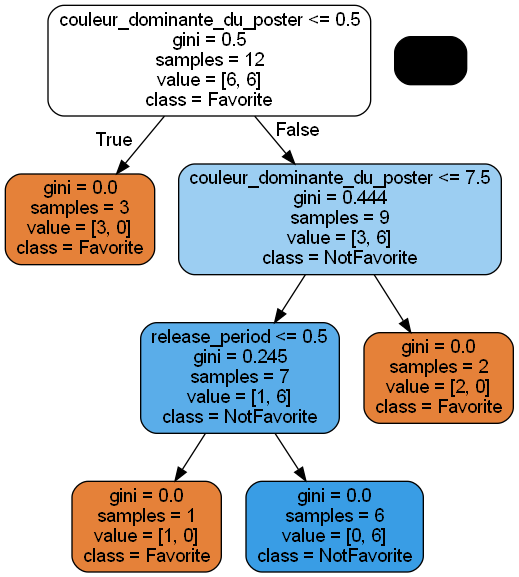

In [193]:
liste_profil_users = []
index = 0
for user,liste_pref in users_preferences.items():
    data2 = data2_copy.copy()
    
    resultframe = pd.DataFrame(liste_pref, columns=["favorite"])

    le1 = LabelEncoder()
    data2["genres"] = le1.fit_transform(data2["genres"])

    le2 = LabelEncoder()
    data2["release_period"] = le2.fit_transform(data2["release_period"])

    le3 = LabelEncoder()
    data2["couleur_dominante_du_poster"] = le3.fit_transform(data2["couleur_dominante_du_poster"])

    le4 = LabelEncoder()
    resultframe["favorite"] = le4.fit_transform(resultframe["favorite"])

    # Use of decision tree classifiers
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(data2.values, resultframe)


    #===Initialisation===
    liste_genres = []
    liste_period = []
    liste_couleur = []
    liste_prediction_chiffre = []
    liste_prediction_lettre = [] #pour pouvoir voir les tags que l'utilisateur aime
    liste_tag_favoris = [] 
    liste_suggestion_favoris = []
    
    liste_genres_pref = []
    liste_period_pref = []
    liste_couleur_pref = []

    for dico in data2_copy.to_dict(orient="records"): #on prend tous les genres, period et couleur dominante trouvée dans les posters téléchargés
        if dico["genres"] not in liste_genres:
            liste_genres.append(dico["genres"])
        if dico["release_period"] not in liste_period:
            liste_period.append(dico["release_period"])
        if dico["couleur_dominante_du_poster"] not in liste_couleur:
            liste_couleur.append(dico["couleur_dominante_du_poster"])

    for i in range(0,30): #on génère 30 listes avec des choix de "genre", "release_period" et "couleur_dominante_du_poster" aléatoirement
        liste_prediction_chiffre.append([le1.transform([random.choice(liste_genres)])[0],le2.transform([random.choice(liste_period)])[0],le3.transform([random.choice(liste_couleur)])[0]])
        liste_prediction_lettre.append([random.choice(liste_genres),random.choice(liste_period),random.choice(liste_couleur)]) 

    print("---SUGGESTIONS OF TAGS---", liste_prediction_lettre)

    
    #===Prédiction===
    prediction = dtc.predict(liste_prediction_chiffre)
    print("\n",le4.inverse_transform(prediction))
    print("\n","---IMPORTANCE OF TAGS---",dtc.feature_importances_)

    
    #===Affichage des suggestions favoris===
    for liste_de_tags, favoris_ou_non in zip(liste_prediction_lettre,le4.inverse_transform(prediction)):
        if favoris_ou_non == "Favorite": #on récupère uniquement les listes de tags aléatoires qui ont plu à l'utilisateur
            liste_suggestion_favoris.append(liste_de_tags)
    print("\n","---FAVORITE SUGGESTIONS---",liste_suggestion_favoris)

    
    #===Récupération des tags favoris===
    liste_allTags = []

    for liste in liste_suggestion_favoris:
        for tag in liste:
            liste_allTags.append(tag)
    
    tag_counter = Counter(liste_allTags) #permet de compter l'occurrence de chaque tag dans liste_tags

    for tag,occurrence in tag_counter.items():
        if occurrence > 1: #on prend que les tags qui apparaissent plus d'une fois dans les tags après prédiciton
            liste_tag_favoris.append(tag)
    print("\n","---FAVORITE TAGS---",liste_tag_favoris)
    
    
    #===Récupération des genres, periodes et couleurs favoris=== 
    dico_temp = {}
            
    for tag_favoris in liste_tag_favoris:
        if tag_favoris in liste_genres and tag_favoris not in liste_genres_pref:
            liste_genres_pref.append(tag_favoris)
        if tag_favoris in liste_period and tag_favoris not in liste_period_pref:
            liste_period_pref.append(tag_favoris)
        if tag_favoris in liste_couleur and tag_favoris not in liste_couleur_pref:
            liste_couleur_pref.append(tag_favoris)
        
    print("\n","---FAVORITE GENRES---",liste_genres_pref)
    print("\n","---FAVORITE PERIODS---",liste_period_pref)
    print("\n","---FAVORITE COLORS---",liste_couleur_pref)
    
    dico_temp["Favorite_genres"] = liste_genres_pref
    dico_temp["Favorite_periods"] = liste_period_pref
    dico_temp["Favorite_colors"] = liste_couleur_pref
    
    liste_profil_users.append(dico_temp)
    
    
    #===RECOMMENDATION===
    liste_poster_favoris = []
    breaker1 = False
    breaker2 = False
    for tag in liste_tag_favoris:
        if breaker1 == False:
            for dico_des_films in liste_film_couleur_dominante_trouvee:

                if tag in dico_des_films.values(): #si le tag favoris appartient à un des films téléchargés
                    image = mpimg.imread('images/' + dico_des_films['title'].replace(' ', '_') + '.jpg')
                    plot.imshow(image)
                    plot.axis('off')
                    plot.show()
                    ask = input(user + ": Favorite or Not Favorite ? (y/n --- stop => s):")
                    if ask == 'y':
                        liste_poster_favoris.append(dico_des_films['title'])
                    elif ask == 'n':
                        continue
                    elif ask == 's':
                        breaker1 = True
                        breaker2 = True
                if breaker1 == True and breaker2 == True:
                    break
    
    dico_temp["Favorite_posters"] = liste_poster_favoris
    print("---FAVORITE FILMS---",liste_poster_favoris)
    print("\n")
    
    dot_data = tree.export_graphviz(
    dtc,
    out_file=None,
    feature_names=data2.columns,
    filled=True,
    rounded=True,
    class_names=le4.inverse_transform(resultframe.favorite.unique()),
    )
    graph = graphviz.Source(dot_data)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    img = IPython.display.Image(pydot_graph.create_png())
    print("===VOICI L'ARBRE DE DECISION POUR L'UTILISATEUR " + str(index) + "===")
    index += 1 #on incrémente le numéro de l'utilisateur
    IPython.display.display(img)

pd.DataFrame(liste_profil_users, columns=["Favorite_posters","Favorite_genres","Favorite_periods","Favorite_colors"]).to_json(os.path.join(os.getcwd(),'data','Users_Preferences.json'),orient="records", indent=4)

<AxesSubplot:xlabel='couleur_dominante_du_poster'>

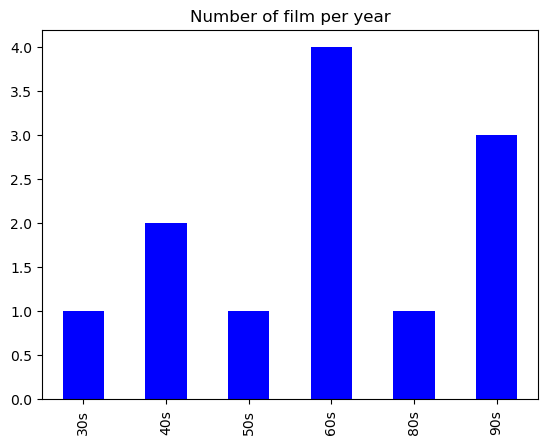

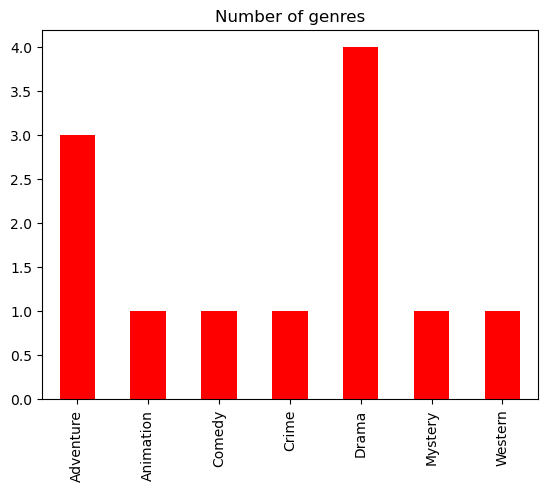

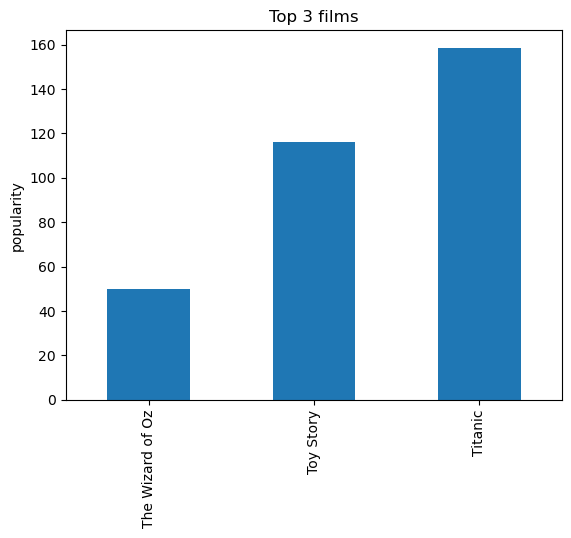

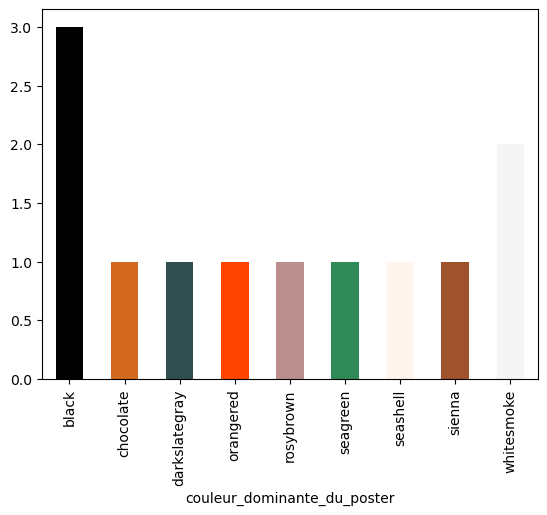

In [194]:
#===VISUALISATION DES CARACTERISTIQUES DE TOUTES LES IMAGES TELECHARGEES===

# 1) Nombre de films par année
grouped = data2_copy.groupby("release_period").count()
grouped = grouped.rename(columns={"release_period": "count"}).reset_index()
grouped.plot(x=0, kind="bar", title="Number of film per year", xlabel='', legend=False, color="blue")

# 2) Nombre de genres différents
grouped1 = data2_copy.groupby("genres").count()
grouped1 = grouped1.rename(columns={"genres": "count"}).reset_index()
grouped1.plot(x=0, kind="bar", title="Number of genres", xlabel='', legend=False, color="red")

# Classement des 3 plus gros films téléchargés
grouped2 = data3.sort_values(by=["popularity"]).tail(3)
grouped2.plot.bar(title="Top 3 films", x='title', y='popularity', xlabel='', ylabel='popularity', legend=False)

# 3) Couleur dominante dans les posters téléchargés
sorted_dict = dict(sorted(dico_couleur.items())) 
grouped3 = data2_copy.groupby("couleur_dominante_du_poster").count()
grouped3.plot.bar(y='genres', legend=False, color = sorted_dict)

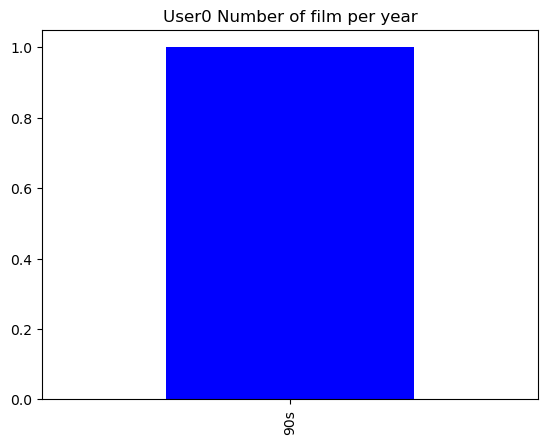

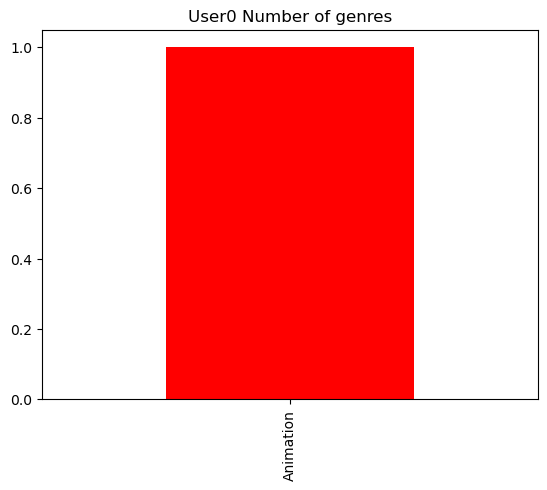

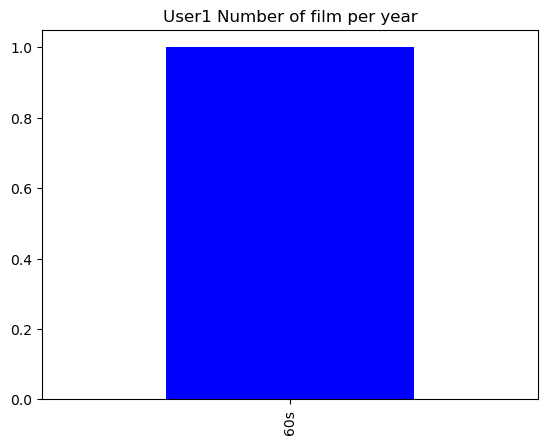

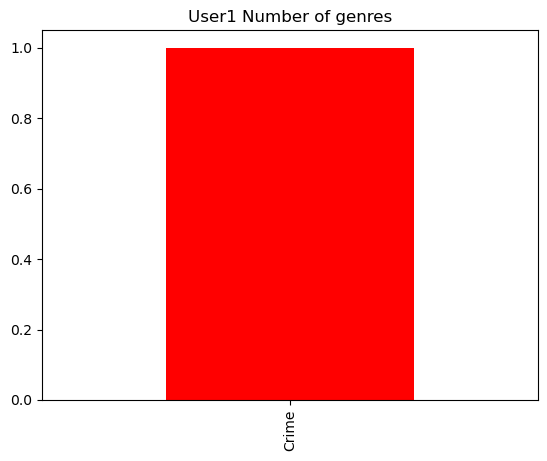

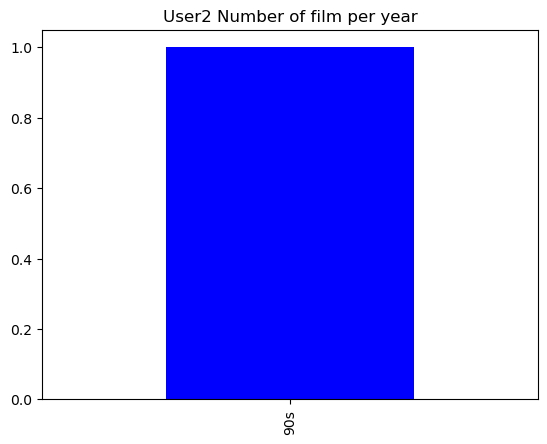

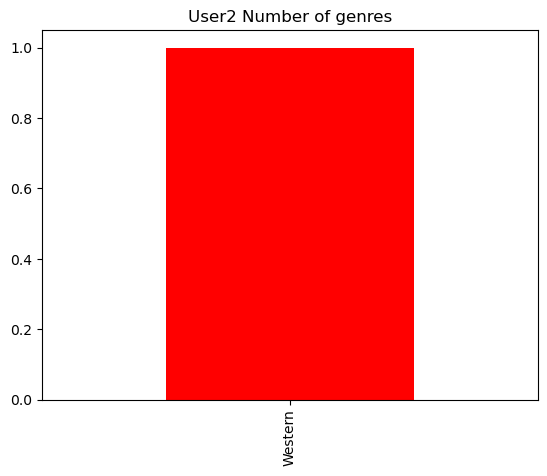

In [195]:
#===VISUALISATION DES CARACTERISTIQUES DES FILMS FAVORIS POUR CHAQUE UTILISATEUR===

path = os.path.join(os.getcwd(),'data','Users_Preferences.json')
with open(path, "r") as fichier_des_preferences:
    data = json.load(fichier_des_preferences)

data4 = pd.DataFrame(liste_film_couleur_dominante_trouvee)
data4 = data4[['title','genres','release_period']]

i=0

for users in data: #pour chaque utilisateurs existants
    dico_link_title_periods = {}
    dico_link_title_genres = {}
    liste_period = []
    liste_genres = []
    dico_link_title_periods['titles'] = users["Favorite_posters"]
    dico_link_title_genres['titles'] = users["Favorite_posters"]
        
    for posters_favoris in users["Favorite_posters"]: #on associe les posters favoris avec leur periode respective de sortie et genre
        liste_period.append(data4[data4['title']==posters_favoris]['release_period'].to_string(index=False))
        liste_genres.append(data4[data4['title']==posters_favoris]['genres'].to_string(index=False))
    
    
    dico_link_title_periods['periods'] = liste_period
    dico_link_title_genres['genres'] = liste_genres 
    
    data5 = pd.DataFrame(dico_link_title_periods)
    data6 = pd.DataFrame(dico_link_title_genres)
    
    # 1) Nombre de film par année pour les films favoris
    grouped = data5.groupby("periods").count()
    grouped = grouped.rename(columns={"periods": "count"}).reset_index()
    grouped.plot(x=0, kind="bar", title= "User" + str(i) + " Number of film per year", xlabel='', legend=False, color="blue")
    
    # 2) Nombre de genres différents pour les films favoris
    grouped = data6.groupby("genres").count()
    grouped = grouped.rename(columns={"genres": "count"}).reset_index()
    grouped.plot(x=0, kind="bar", title= "User" + str(i) + " Number of genres", xlabel='', legend=False, color="red")
    
    i +=1 #on incrémente le numéro de l'utilisateur